In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


# Utilities

In [5]:
def pad_events(events, val=0, max_length=None):
    event_lengths = [event.shape[0] for event in events]
    if max_length is None:
        max_length = max(event_lengths)
    return np.asarray([np.vstack((event, val*np.ones((max_length - ev_len, event.shape[1]))))
                     for event,ev_len in zip(events, event_lengths)])

# events: a numpy object array of numpy arrays of events
def pad_events_generator(events, targets,  batch_size, weights = None):
    num_events = len(events)
    
#     events = np.asarray([event if len(event) >= initial_pad else 
#                              np.vstack((event, np.zeros((initial_pad - len(event), event.shape[1]))))
#                              for event in events])
    
    while True:
        start = 0
        while start < num_events:
            end = min(start + batch_size, num_events)
            if weights is None:
                yield pad_events(events[start:end]), targets[start:end]
            else:
                yield pad_events(events[start:end]), targets[start:end], weights[start:end]
            start = end

# Load Data

In [51]:
# base_dir = '/data0/users/aandreassen/DCTRHunting/'
# sample0 = np.load(base_dir + 'herwig_full_event_with_mass_preprocessed.npy', allow_pickle=True)
# sample1 = np.load(base_dir + 'pythia_full_event_with_mass_preprocessed.npy', allow_pickle=True)
# signal  = np.load(base_dir + 'signal_full_event_with_mass_preprocessed.npy', allow_pickle=True)

In [ ]:
# print(max([len(s) for s in sample0]))
# print(max([len(s) for s in sample1]))
# print(max([len(s) for s in signal]))

In [52]:
#sample0_padded = pad_events(sample0, max_length = 551)
#sample1_padded = pad_events(sample1, max_length = 551)
#signal_padded = pad_events(signal, max_length = 551)

#np.save(base_dir + 'herwig_full_event_with_mass_preprocessed_padded.npy', sample0_padded)
#np.save(base_dir + 'pythia_full_event_with_mass_preprocessed_padded.npy', sample1_padded)
#np.save(base_dir + 'signal_full_event_with_mass_preprocessed_padded.npy', signal_padded)

In [57]:
base_dir = '/data0/users/aandreassen/DCTRHunting/'
sample0 = np.load(base_dir + 'herwig_leading_two_jets_with_mass_preprocessed_padded.npy', allow_pickle=True)
sample1 = np.load(base_dir + 'pythia_leading_two_jets_with_mass_preprocessed_padded.npy', allow_pickle=True)[:990000]
signal  = np.load(base_dir + 'signal_leading_two_jets_with_mass_preprocessed_padded.npy', allow_pickle=True)[:10000]

In [58]:
SR_low  = 3250/1000
SR_high = 3750/1000

In [59]:
sample0_SR = [event for event in sample0 if event[0,-1]>SR_low and event[0,-1]<SR_high]
sample0_BR = [event for event in sample0 if event[0,-1]<SR_low or  event[0,-1]>SR_high]

In [60]:
sample1_SR = [event for event in sample1 if event[0,-1]>SR_low and event[0,-1]<SR_high]
sample1_BR = [event for event in sample1 if event[0,-1]<SR_low or  event[0,-1]>SR_high]

In [61]:
signal_SR = [event for event in signal if event[0,-1]>SR_low and event[0,-1]<SR_high]
signal_BR = [event for event in signal if event[0,-1]<SR_low or  event[0,-1]>SR_high]

In [62]:
len(signal_SR)/len(sample1_SR)

0.0547044069277248

In [63]:
y0 = np.zeros(len(sample0_BR))
y1 = np.ones(len(sample1_BR))
ys = np.ones(len(signal_BR))

In [64]:
X = np.concatenate([sample0_BR, sample1_BR, signal_BR], axis=0)
y = np.concatenate([y0, y1, ys], axis=0)

In [65]:
Y = to_categorical(y, num_classes=2)

In [66]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=0.1, test=0)

In [67]:
n_train = len(X_train)
n_val = len(X_val)

## SR

In [68]:
y0_SR = np.zeros(len(sample0_SR))
y1_SR = np.ones(len(sample1_SR))
ys_SR = np.ones(len(signal_SR))

In [69]:
X_SR = np.concatenate([sample0_SR, sample1_SR, signal_SR], axis=0)
y_SR = np.concatenate([y0_SR, y1_SR, ys_SR], axis=0)

In [70]:
Y_SR = to_categorical(y_SR, num_classes=2)

In [71]:
# do train/val/test split 
(X_SR_train, X_SR_val, X_SR_test,
 Y_SR_train, Y_SR_val, Y_SR_test) = data_split(X_SR, Y_SR, val=0.1, test=0)

In [72]:
n_SR_train = len(X_SR_train)
n_SR_val = len(X_SR_val)

# Build Model

In [73]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# build architecture
pfn = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               
____________________________________________________________________________________________

# Train Model

In [74]:
batch_size = 1000

In [75]:
earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('./saved_models/pythia_pythia-with-signal.model', save_best_only=True)

callbacks = [earlystopping, checkpoint]

In [ ]:
# train model
pfn.fit(X_train, Y_train,
                  epochs=20,
                  validation_data=(X_val, Y_val),
                  verbose=1, 
                  callbacks = callbacks)

Train on 1518229 samples, validate on 168692 samples
Epoch 1/20
    192/1518229 [..............................] - ETA: 4:24:44 - loss: 90.5241 - acc: 0.5312 

/home/aandreassen/python-envs/py36/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.128360). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  34112/1518229 [..............................] - ETA: 18:57 - loss: 2.6969 - acc: 0.5132

# Get Weights

In [32]:
train_preds = pfn.predict_generator(pad_events_generator(X_SR_train, Y_SR_train, batch_size),
                  steps=n_SR_train/batch_size,
                  verbose=1)

168/167 [==============================] - 4s 21ms/step


In [33]:
val_preds = pfn.predict_generator(pad_events_generator(X_SR_val, Y_SR_val, batch_size),
                  steps=n_SR_val/batch_size,
                  verbose=1)

19/18 [==============================] - 0s 23ms/step


In [34]:
weights_SR_train = train_preds[:,1]/train_preds[:,0]
weights_SR_val = val_preds[:,1]/val_preds[:,0]

In [35]:
for i,(y, _) in enumerate(Y_SR_train):
  # Don't reweigth elements from class 1 y==0 <-> target ==[0, 1]
  if y == 0:
    weights_SR_train[i] = 1

In [36]:
for i,(y, _) in enumerate(Y_SR_val):
  # Don't reweigth elements from class 1 y==0 <-> target ==[0, 1]
  if y == 0:
    weights_SR_val[i] = 1

In [53]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# build architecture
pfn2 = PFN(input_dim=4, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('pythia_pythia-with-signal_SR.model', save_best_only=True)

callbacks = [earlystopping, checkpoint]

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_15 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_15[0][0]              
____________________________________________________________________________________________

In [54]:
batch_size = 1000

In [55]:
# train model
pfn2.fit_generator(pad_events_generator(X_SR_train, Y_SR_train, batch_size, weights_SR_train),
                  epochs=5,
                  steps_per_epoch=n_SR_train/batch_size,
                  validation_data=pad_events_generator(X_SR_val, Y_SR_val, batch_size, weights_SR_val),
                  validation_steps=n_SR_val/batch_size,
                  verbose=1, 
                  callbacks = callbacks)

Epoch 1/5
168/167 [==============================] - 6s 34ms/step - loss: 12.3268 - acc: 0.4991 - val_loss: 1.9443 - val_acc: 0.5154
Epoch 2/5
168/167 [==============================] - 5s 29ms/step - loss: 1.4450 - acc: 0.5001 - val_loss: 1.2400 - val_acc: 0.5177
Epoch 3/5
168/167 [==============================] - 5s 30ms/step - loss: 1.0286 - acc: 0.4988 - val_loss: 1.0986 - val_acc: 0.5166
Epoch 4/5
168/167 [==============================] - 5s 30ms/step - loss: 0.9330 - acc: 0.5000 - val_loss: 0.8247 - val_acc: 0.4857
Epoch 5/5
168/167 [==============================] - 5s 30ms/step - loss: 1.0040 - acc: 0.4990 - val_loss: 0.8383 - val_acc: 0.4854


# ROC Curves

In [56]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

In [57]:
final_preds = pfn2.predict_generator(pad_events_generator(X_SR_val, Y_SR_val, batch_size),
                  steps=n_SR_val/batch_size,
                  verbose=1)

19/18 [==============================] - 0s 22ms/step


In [58]:
roc = roc_curve(Y_SR_val.argmax(axis = -1), final_preds[:,1], weights_SR_val)

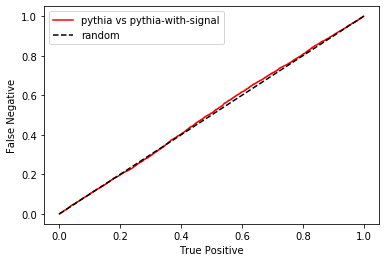

In [59]:
plt.plot(roc[0], roc[1], label='pythia vs pythia-with-signal', color='red')
plt.plot([0,1],[0,1], label='random', ls="--", color='k')
plt.xlabel("True Positive")
plt.ylabel("False Negative")
plt.legend()
plt.show()

In [60]:
y_signal = np.ones(len(signal))
signal_preds = pfn2.predict_generator(pad_events_generator(signal, to_categorical(y_signal, 2), batch_size),
                  steps=len(signal)/batch_size,
                  verbose=1)

signal_weights = pfn.predict_generator(pad_events_generator(signal, to_categorical(y_signal, 2), batch_size),
                  steps=len(signal)/batch_size,
                  verbose=1)

signal_weights = signal_weights[:,1]/signal_weights[:,0]

10/10 [==============================] - 0s 26ms/step


In [61]:
y_pythia = np.zeros(len(pythia1))
pythia_preds = pfn2.predict_generator(pad_events_generator(pythia1, to_categorical(y_pythia, 2), batch_size),
                  steps=len(pythia1)/batch_size,
                  verbose=1)

pythia_weights = pfn.predict_generator(pad_events_generator(pythia1, to_categorical(y_pythia, 2), batch_size),
                  steps=len(pythia1)/batch_size,
                  verbose=1)

pythia_weights = pythia_weights[:,1]/pythia_weights[:,0]

990/990 [==============================] - 20s 20ms/step


In [62]:
len(pythia1)

990000

In [63]:
y_roc = np.concatenate([y_signal, y_pythia])

In [64]:
preds_roc = np.concatenate([signal_preds, pythia_preds])[:,1]

In [65]:
weights_roc = np.concatenate([signal_weights, pythia_weights])

In [66]:
sig_roc = roc_curve(y_roc, preds_roc, sample_weight = weights_roc)

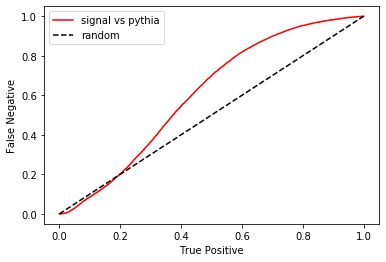

In [67]:
plt.plot(sig_roc[0], sig_roc[1], label='signal vs pythia', color='red')
plt.plot([0,1],[0,1], label='random', ls="--", color='k')
plt.xlabel("True Positive")
plt.ylabel("False Negative")
plt.legend(loc='best')
plt.show()

/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


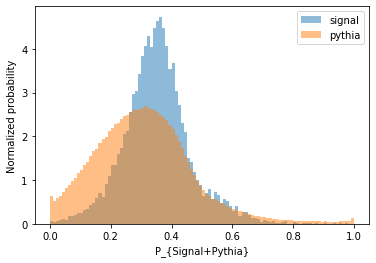

In [68]:
plt.hist(signal_preds[:,1], bins = np.linspace(0,1,101), alpha = 0.5, normed=True, label = 'signal', weights=signal_weights)
plt.hist(pythia_preds[:,1], bins = np.linspace(0,1,101), alpha = 0.5, normed=True, label='pythia', weights=pythia_weights)
plt.legend(loc='best')
plt.xlabel("P_{Signal+Pythia}")
plt.ylabel("Normalized probability")
plt.show()

/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


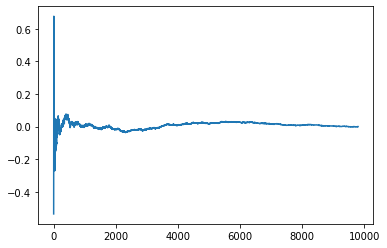

In [69]:
plt.plot((roc[1]-roc[0])/roc[0])

In [70]:
roc_now = roc_curve(Y_SR_val.argmax(axis = -1), val_preds[:,1])

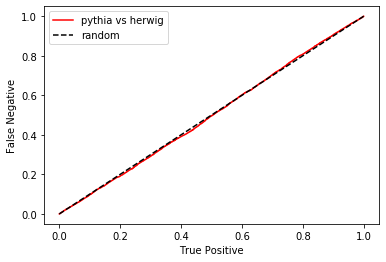

In [71]:
plt.plot(roc_now[0], roc_now[1], label='pythia vs herwig', color='red')
plt.plot([0,1],[0,1], label='random', ls="--", color='k')
plt.xlabel("True Positive")
plt.ylabel("False Negative")
plt.legend()
plt.show()

In [40]:
roc_now[1]-roc[1]

ValueError: operands could not be broadcast together with shapes (2,) (16504,) 

In [ ]:
roc_now

In [ ]:
val_preds[:,1].shape